In [ ]:
import json
import os
import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database',)).History will not be written to the database.


### Constants

In [71]:
first_cols = ['cardNum', 'boarding_datetime','gps_datetime','route','busCode','stopPointId']
boarding_key_cols = ['cardNum','boarding_datetime']
gps_key_cols = ['route','busCode','tripNum','stopPointId']
sort_cols = boarding_key_cols + gps_key_cols[:-1] + ['gps_datetime']
max_match_diff = 1500

### Code

#### Reading Boarding data

In [3]:
boarding_data = pd.read_csv('/local/tarciso/masters/data/bus_trips/test/doc1-2017_05_10.csv')

In [4]:
boarding_data.head()

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M
1,542,BAIRRO NOVO B,GA117,2357837,17:25:14,09/05/17,23/03/72,F
2,000,OPER S/LINHA,09053,2357837,17:57:33,09/05/17,23/03/72,F
3,000,OPER S/LINHA,09053,2357837,17:57:28,09/05/17,23/03/72,F
4,021,INTERB II ANTI H,08046,1937533,20:17:34,09/05/17,26/01/72,F


In [5]:
boarding_data.dtypes

CODLINHA          object
NOMELINHA         object
CODVEICULO        object
NUMEROCARTAO       int64
HORAUTILIZACAO    object
DATAUTILIZACAO    object
DATANASCIMENTO    object
SEXO              object
dtype: object

In [6]:
len(boarding_data)

320292

#### Adding datetime column to ticketing dataframe 

In [7]:
boarding_data['boarding_datetime'] = pd.to_datetime(boarding_data['DATAUTILIZACAO'] + ' ' + boarding_data['HORAUTILIZACAO'],format='%d/%m/%y %H:%M:%S')

#### Reading BUSTE data

In [8]:
buste_data = pd.read_csv('/local/tarciso/masters/data/bus_trips/test/buste-version-its-april-2018/2017_05_09.csv', dtype = {'route': str}, na_values='-')

In [9]:
buste_data.head()

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date
0,500,1.0,4130,6463875,-25.501550,-49.237590,2129.862,GE718,NaN,NaN,...,NaN,06:37:02,27472,BETWEEN,NaN,NaN,NaN,NaN,NaN,2017_05_09
1,500,1.0,4130,6463945,-25.481825,-49.246977,4513.260,GE718,NaN,-25.481693,...,15.561821,06:42:45,27551,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017_05_09
2,500,1.0,4130,6464041,-25.459174,-49.258160,7268.131,GE718,NaN,NaN,...,NaN,06:47:54,25471,BETWEEN,NaN,NaN,NaN,NaN,NaN,2017_05_09
3,500,1.0,4130,6464140,-25.438837,-49.268129,9735.966,GE718,NaN,-25.438738,...,12.105323,06:53:44,25515,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017_05_09
4,500,1.0,4130,6464167,-25.433790,-49.270262,10543.422,GE718,NaN,-25.433916,...,21.556105,06:58:25,27560,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017_05_09


In [10]:
buste_data.dtypes

route                     object
tripNum                  float64
shapeId                    int64
shapeSequence              int64
shapeLat                 float64
shapeLon                 float64
distanceTraveledShape    float64
busCode                   object
gpsPointId               float64
gpsLat                   float64
gpsLon                   float64
distanceToShapePoint     float64
timestamp                 object
stopPointId                int64
problem                   object
birthdate                 object
cardTimestamp             object
lineName                  object
cardNum                  float64
gender                    object
date                      object
dtype: object

#### Add date and datetime to gps dataframe

In [11]:
buste_data['gps_datetime'] = pd.to_datetime(buste_data['date'] + ' ' + buste_data['timestamp'],format='%Y_%m_%d %H:%M:%S')
buste_data['boarding_datetime'] = pd.to_datetime(buste_data['date'] + ' ' + buste_data['cardTimestamp'],format='%Y_%m_%d %H:%M:%S')

In [14]:
buste_data[['date','gps_datetime','boarding_datetime']][pd.notnull(buste_data['boarding_datetime'])].head(10)

,date,gps_datetime,boarding_datetime
148,2017_05_09,2017-05-09 06:16:34,2017-05-09 06:17:31
150,2017_05_09,2017-05-09 06:18:08,2017-05-09 06:19:04
151,2017_05_09,2017-05-09 06:18:08,2017-05-09 06:19:00
152,2017_05_09,2017-05-09 06:18:08,2017-05-09 06:18:15
153,2017_05_09,2017-05-09 06:18:08,2017-05-09 06:18:11
154,2017_05_09,2017-05-09 06:19:18,2017-05-09 06:19:34
155,2017_05_09,2017-05-09 06:20:46,2017-05-09 06:21:39
157,2017_05_09,2017-05-09 06:23:04,2017-05-09 06:23:53
158,2017_05_09,2017-05-09 06:23:56,2017-05-09 06:24:41
163,2017_05_09,2017-05-09 06:29:02,2017-05-09 06:30:09


In [15]:
other_cols = [col for col in buste_data.columns if col not in first_cols]
cols_order = first_cols + other_cols
gps_by_boarding = buste_data[cols_order] \
    .sort_values(boarding_key_cols)
gps_by_boarding.head(10)

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date
558392,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:49,654,HA017,35350,2.0,2953,3848651,-25.492612,...,NaN,NaN,NaN,06:28:49,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017_05_09
260499,257342.0,2017-05-09 07:48:58,2017-05-09 07:47:51,511,EA172,31195,4.0,2746,5846156,-25.498727,...,-25.498735,-49.247771,9.667548,07:47:51,NO_PROBLEM,24/01/71,07:48:58,SÃO FRANCISCO,F,2017_05_09
408836,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,3.0,2106,6040871,-25.501307,...,-25.501313,-49.319971,0.737270,06:55:54,NO_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017_05_09
199446,304127.0,2017-05-09 10:24:50,2017-05-09 10:22:28,175,BC010,31748,5.0,1743,5444496,-25.450869,...,-25.450986,-49.254015,13.270845,10:22:28,NO_PROBLEM,09/06/54,10:24:50,BOM RETIRO / PUC,M,2017_05_09
305000,304127.0,2017-05-09 10:57:36,2017-05-09 10:42:18,370,LC016,3377,3.0,3669,6592154,-25.428220,...,-25.428210,-49.246896,5.426374,10:42:18,NO_PROBLEM,09/06/54,10:57:36,RUA XV / BARIGUI,M,2017_05_09
517064,304627.0,2017-05-09 14:17:23,2017-05-09 14:16:09,370,BC032,3377,6.0,2789,5510110,-25.428214,...,-25.428125,-49.246675,18.124441,14:16:09,NO_PROBLEM,05/04/53,14:17:23,RUA XV / BARIGUI,F,2017_05_09
421546,304627.0,2017-05-09 16:24:40,2017-05-09 15:45:37,370,LC020,30303,6.0,2789,5510843,-25.455839,...,-25.455803,-49.323013,5.475631,15:45:37,NO_PROBLEM,05/04/53,16:24:40,RUA XV / BARIGUI,F,2017_05_09
108958,306135.0,2017-05-09 07:56:49,2017-05-09 07:56:48,777,JC004,32097,3.0,2194,4299781,-25.446370,...,-25.446305,-49.275308,32.238018,07:56:48,NO_PROBLEM,29/10/52,07:56:49,V. VELHA,M,2017_05_09
258047,310241.0,2017-05-09 17:55:48,2017-05-09 17:55:42,468,DC090,30884,5.0,1926,4418132,-25.455683,...,-25.455618,-49.241156,8.323350,17:55:42,NO_PROBLEM,13/01/72,17:55:48,JD. ITIBERÊ,M,2017_05_09
112368,312500.0,2017-05-09 13:26:11,2017-05-09 13:24:48,175,BC282,28632,6.0,2743,5404932,-25.431576,...,-25.431573,-49.271680,6.383659,13:24:48,NO_PROBLEM,26/02/82,13:26:11,BOM RETIRO / PUC,F,2017_05_09


In [16]:
len(gps_by_boarding)

642639

#### Filtering out BUSTE entries whose GPS-Ticketing match time difference is higher than 30 minutes

In [17]:
gps_by_boarding['match_diff'] = (gps_by_boarding['boarding_datetime'] - gps_by_boarding['gps_datetime']).astype('timedelta64[s]')

In [18]:
gps_by_boarding_filtered = gps_by_boarding[np.abs(gps_by_boarding['match_diff']) <= max_match_diff]
gps_by_boarding_filtered

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
558392,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:49,654,HA017,35350,2.0,2953,3848651,-25.492612,...,NaN,NaN,06:28:49,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017_05_09,20.0
260499,257342.0,2017-05-09 07:48:58,2017-05-09 07:47:51,511,EA172,31195,4.0,2746,5846156,-25.498727,...,-49.247771,9.667548,07:47:51,NO_PROBLEM,24/01/71,07:48:58,SÃO FRANCISCO,F,2017_05_09,67.0
408836,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,3.0,2106,6040871,-25.501307,...,-49.319971,0.737270,06:55:54,NO_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017_05_09,51.0
199446,304127.0,2017-05-09 10:24:50,2017-05-09 10:22:28,175,BC010,31748,5.0,1743,5444496,-25.450869,...,-49.254015,13.270845,10:22:28,NO_PROBLEM,09/06/54,10:24:50,BOM RETIRO / PUC,M,2017_05_09,142.0
305000,304127.0,2017-05-09 10:57:36,2017-05-09 10:42:18,370,LC016,3377,3.0,3669,6592154,-25.428220,...,-49.246896,5.426374,10:42:18,NO_PROBLEM,09/06/54,10:57:36,RUA XV / BARIGUI,M,2017_05_09,918.0
517064,304627.0,2017-05-09 14:17:23,2017-05-09 14:16:09,370,BC032,3377,6.0,2789,5510110,-25.428214,...,-49.246675,18.124441,14:16:09,NO_PROBLEM,05/04/53,14:17:23,RUA XV / BARIGUI,F,2017_05_09,74.0
108958,306135.0,2017-05-09 07:56:49,2017-05-09 07:56:48,777,JC004,32097,3.0,2194,4299781,-25.446370,...,-49.275308,32.238018,07:56:48,NO_PROBLEM,29/10/52,07:56:49,V. VELHA,M,2017_05_09,1.0
258047,310241.0,2017-05-09 17:55:48,2017-05-09 17:55:42,468,DC090,30884,5.0,1926,4418132,-25.455683,...,-49.241156,8.323350,17:55:42,NO_PROBLEM,13/01/72,17:55:48,JD. ITIBERÊ,M,2017_05_09,6.0
112368,312500.0,2017-05-09 13:26:11,2017-05-09 13:24:48,175,BC282,28632,6.0,2743,5404932,-25.431576,...,-49.271680,6.383659,13:24:48,NO_PROBLEM,26/02/82,13:26:11,BOM RETIRO / PUC,F,2017_05_09,83.0
404554,312823.0,2017-05-09 13:35:49,2017-05-09 13:34:57,652,LA001,34977,13.0,2101,3834325,-25.534607,...,-49.331276,14.430964,13:34:57,NO_PROBLEM,03/09/88,13:35:49,V. VERDE,F,2017_05_09,52.0


In [20]:
print gps_by_boarding_filtered['match_diff'].describe()

count    139531.000000
mean         83.926755
std         163.364311
min       -1313.000000
25%          17.000000
50%          48.000000
75%          69.000000
max        1499.000000
Name: match_diff, dtype: float64


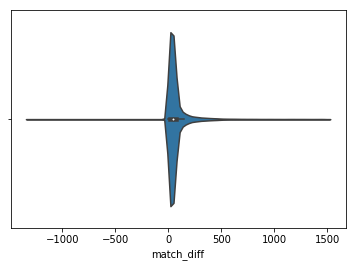

In [21]:
sns.violinplot(x='match_diff', data=gps_by_boarding_filtered[(gps_by_boarding_filtered['match_diff'] > -max_match_diff) & (gps_by_boarding_filtered['match_diff'] < max_match_diff)])

In [23]:
num_single_boardings = len(gps_by_boarding.drop_duplicates(subset=boarding_key_cols))
num_matched_boardings = len(gps_by_boarding_filtered)
num_missed_boardings = num_single_boardings - num_matched_boardings
perc_matched_boardings = num_matched_boardings/float(num_single_boardings)
perc_missed_boardings = num_missed_boardings/float(num_single_boardings)
print "single boardings: {}, selected boardings: {} ({}), boardings filtered (large matchdiff) = {} ({})".format(num_single_boardings, num_matched_boardings, perc_matched_boardings, num_missed_boardings, perc_missed_boardings)

single boardings: 144669, selected boardings: 139531 (0.964484443799), boardings filtered (large matchdiff) = 5138 (0.0355155562007)


In [24]:
trips_per_user = gps_by_boarding_filtered.groupby(['cardNum']).cardNum.count().reset_index(name='num_trips').num_trips.value_counts(normalize=True) \
                    .reset_index(name='num_trips', level=0)

In [25]:
trips_per_user

,index,num_trips
0,1,0.751818
1,2,0.208254
2,3,0.028545
3,4,0.009244
4,5,0.001270
5,6,0.000654
6,7,0.000112
7,8,0.000065
8,10,0.000019
9,9,0.000019


## Build final BUSTE dataset

#### Ticketing and GPS matches

In [26]:
gps_by_boarding_filtered.head()

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
558392,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:49,654,HA017,35350,2.0,2953,3848651,-25.492612,...,NaN,NaN,06:28:49,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017_05_09,20.0
260499,257342.0,2017-05-09 07:48:58,2017-05-09 07:47:51,511,EA172,31195,4.0,2746,5846156,-25.498727,...,-49.247771,9.667548,07:47:51,NO_PROBLEM,24/01/71,07:48:58,SÃO FRANCISCO,F,2017_05_09,67.0
408836,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,3.0,2106,6040871,-25.501307,...,-49.319971,0.737270,06:55:54,NO_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017_05_09,51.0
199446,304127.0,2017-05-09 10:24:50,2017-05-09 10:22:28,175,BC010,31748,5.0,1743,5444496,-25.450869,...,-49.254015,13.270845,10:22:28,NO_PROBLEM,09/06/54,10:24:50,BOM RETIRO / PUC,M,2017_05_09,142.0
305000,304127.0,2017-05-09 10:57:36,2017-05-09 10:42:18,370,LC016,3377,3.0,3669,6592154,-25.428220,...,-49.246896,5.426374,10:42:18,NO_PROBLEM,09/06/54,10:57:36,RUA XV / BARIGUI,M,2017_05_09,918.0


In [27]:
len(gps_by_boarding_filtered)

139531

#### Check for registries with null boarding or location data

In [29]:
len(gps_by_boarding_filtered[pd.isnull(gps_by_boarding_filtered['cardNum']) | pd.isnull(gps_by_boarding_filtered['boarding_datetime'])])

0

In [30]:
len(gps_by_boarding_filtered[pd.isnull(gps_by_boarding_filtered['route']) | 
             pd.isnull(gps_by_boarding_filtered['busCode']) |
             pd.isnull(gps_by_boarding_filtered['tripNum']) |
             pd.isnull(gps_by_boarding_filtered['stopPointId']) |
             pd.isnull(gps_by_boarding_filtered['gps_datetime'])])

0

#### GPS with no match / with filtered match

In [32]:
gps_with_no_match = gps_by_boarding[(np.abs(gps_by_boarding['match_diff']) > max_match_diff) | (pd.isnull(gps_by_boarding['match_diff']))]
gps_with_no_match.loc[:,['cardNum','boarding_datetime','birthdate','cardTimestamp','lineName','gender']] = np.nan

In [33]:
gps_with_no_match

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
421546,NaN,NaN,2017-05-09 15:45:37,370,LC020,30303,6.0,2789,5510843,-25.455839,...,-49.323013,5.475631,15:45:37,NO_PROBLEM,NaN,NaN,NaN,NaN,2017_05_09,2343.0
429413,NaN,NaN,2017-05-09 12:58:40,631,GA208,33278,8.0,3369,6595274,-25.512413,...,-49.289261,3.034185,12:58:40,NO_PROBLEM,NaN,NaN,NaN,NaN,2017_05_09,-26708.0
482358,NaN,NaN,2017-05-09 13:47:36,370,LC028,30304,5.0,2789,5510857,-25.458703,...,-49.323503,2.649607,13:47:36,NO_PROBLEM,NaN,NaN,NaN,NaN,2017_05_09,2200.0
587912,NaN,NaN,2017-05-09 12:59:59,040,HB605,34156,3.0,1718,3368987,-25.404344,...,-49.335390,10.035853,12:59:59,NO_PROBLEM,NaN,NaN,NaN,NaN,2017_05_09,-23867.0
583283,NaN,NaN,2017-05-09 06:51:17,021,HB604,28136,1.0,3235,5233298,-25.435866,...,-49.307076,20.858232,06:51:17,NO_PROBLEM,NaN,NaN,NaN,NaN,2017_05_09,1726.0
47501,NaN,NaN,2017-05-09 07:55:32,010,BB310,33171,2.0,1708,5859650,-25.449428,...,-49.254205,8.176641,07:55:32,NO_PROBLEM,NaN,NaN,NaN,NaN,2017_05_09,2526.0
587915,NaN,NaN,2017-05-09 12:59:59,040,HB605,34156,3.0,1718,3368987,-25.404344,...,-49.335390,10.035853,12:59:59,NO_PROBLEM,NaN,NaN,NaN,NaN,2017_05_09,-25520.0
504763,NaN,NaN,2017-05-09 08:15:39,010,BB001,33171,3.0,1708,5859650,-25.449428,...,-49.254193,6.699659,08:15:39,NO_PROBLEM,NaN,NaN,NaN,NaN,2017_05_09,2518.0
504762,NaN,NaN,2017-05-09 08:15:39,010,BB001,33171,3.0,1708,5859650,-25.449428,...,-49.254193,6.699659,08:15:39,NO_PROBLEM,NaN,NaN,NaN,NaN,2017_05_09,2524.0
578140,NaN,NaN,2017-05-09 16:25:38,040,MB301,31029,8.0,1717,3367323,-25.513207,...,-49.295160,3.268860,16:25:38,NO_PROBLEM,NaN,NaN,NaN,NaN,2017_05_09,3622.0


In [39]:
gps_with_no_match_clean = gps_with_no_match.dropna(subset=['route','busCode','tripNum','gps_datetime']) \
                    .drop_duplicates(subset=gps_key_cols)

In [40]:
print len(gps_with_no_match), len(gps_with_no_match_clean), len(gps_with_no_match) - len(gps_with_no_match_clean)

503108 471708 31400


### Building dataset with unique GPS-Ticketing matches and unique GPS records

In [41]:
unique_boarding_gps = pd.concat([gps_by_boarding_filtered,gps_with_no_match_clean])

In [42]:
len(unique_boarding_gps)

611239

In [73]:
unique_boarding_gps = unique_boarding_gps[~((unique_boarding_gps.duplicated(subset=gps_key_cols, keep=False)) & (pd.isnull(unique_boarding_gps['cardNum'])))] \
            .sort_values(sort_cols)

In [74]:
unique_boarding_gps.head(10)

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
558392,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:49,654,HA017,35350,2.0,2953,3848651,-25.492612,...,NaN,NaN,06:28:49,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017_05_09,20.0
260499,257342.0,2017-05-09 07:48:58,2017-05-09 07:47:51,511,EA172,31195,4.0,2746,5846156,-25.498727,...,-49.247771,9.667548,07:47:51,NO_PROBLEM,24/01/71,07:48:58,SÃO FRANCISCO,F,2017_05_09,67.0
408836,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,3.0,2106,6040871,-25.501307,...,-49.319971,0.737270,06:55:54,NO_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017_05_09,51.0
199446,304127.0,2017-05-09 10:24:50,2017-05-09 10:22:28,175,BC010,31748,5.0,1743,5444496,-25.450869,...,-49.254015,13.270845,10:22:28,NO_PROBLEM,09/06/54,10:24:50,BOM RETIRO / PUC,M,2017_05_09,142.0
305000,304127.0,2017-05-09 10:57:36,2017-05-09 10:42:18,370,LC016,3377,3.0,3669,6592154,-25.428220,...,-49.246896,5.426374,10:42:18,NO_PROBLEM,09/06/54,10:57:36,RUA XV / BARIGUI,M,2017_05_09,918.0
517064,304627.0,2017-05-09 14:17:23,2017-05-09 14:16:09,370,BC032,3377,6.0,2789,5510110,-25.428214,...,-49.246675,18.124441,14:16:09,NO_PROBLEM,05/04/53,14:17:23,RUA XV / BARIGUI,F,2017_05_09,74.0
108958,306135.0,2017-05-09 07:56:49,2017-05-09 07:56:48,777,JC004,32097,3.0,2194,4299781,-25.446370,...,-49.275308,32.238018,07:56:48,NO_PROBLEM,29/10/52,07:56:49,V. VELHA,M,2017_05_09,1.0
258047,310241.0,2017-05-09 17:55:48,2017-05-09 17:55:42,468,DC090,30884,5.0,1926,4418132,-25.455683,...,-49.241156,8.323350,17:55:42,NO_PROBLEM,13/01/72,17:55:48,JD. ITIBERÊ,M,2017_05_09,6.0
112368,312500.0,2017-05-09 13:26:11,2017-05-09 13:24:48,175,BC282,28632,6.0,2743,5404932,-25.431576,...,-49.271680,6.383659,13:24:48,NO_PROBLEM,26/02/82,13:26:11,BOM RETIRO / PUC,F,2017_05_09,83.0
404554,312823.0,2017-05-09 13:35:49,2017-05-09 13:34:57,652,LA001,34977,13.0,2101,3834325,-25.534607,...,-49.331276,14.430964,13:34:57,NO_PROBLEM,03/09/88,13:35:49,V. VERDE,F,2017_05_09,52.0


In [45]:
len(unique_boarding_gps)

609954

#### Match station/terminal boarding registries with their respective stop codes

#### Read Terminal/Station Boarding Codes translation table

In [46]:
terminal_codes = pd.read_csv('/local/tarciso/masters/data/urbs/line-000-terminals-translation-table.csv', dtype = {'URBS_CODE': str})

In [47]:
terminal_codes.head()

,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
0,000,TERMINAL BOQUEIRÃO,00001,14489,-25.516723,-49.230568
1,000,TERMINAL BOQUEIRÃO,00002,14489,-25.516723,-49.230568
2,000,TERMINAL BOQUEIRÃO,00003,14489,-25.516723,-49.230568
3,000,TERMINAL CARMO,00004,14485,-25.501311,-49.237825
4,000,TERMINAL CARMO,00005,14485,-25.501311,-49.237825


#### Match CODVEICULO to URBS_CODE to find line 000 boarding stations

In [48]:
matched_station_boarding = boarding_data.merge(terminal_codes, left_on='CODVEICULO', right_on='URBS_CODE', how='inner') \
                        .sort_values(by='DATAUTILIZACAO')

In [49]:
matched_station_boarding.head(10)

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO,boarding_datetime,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M,2017-05-09 11:05:57,000,TERMINAL HAUER,00070,14487,-25.481900,-49.247078
96169,000,OPER S/LINHA,07001,2267326,15:38:38,09/05/17,17/05/58,F,2017-05-09 15:38:38,000,TUBO DE INTEGRAÇÃO-TERMINAL SANTA FELICIDADE,07001,14510,-25.401281,-49.329734
96168,000,OPER S/LINHA,07001,2267326,10:10:22,09/05/17,17/05/58,F,2017-05-09 10:10:22,000,TUBO DE INTEGRAÇÃO-TERMINAL SANTA FELICIDADE,07001,14510,-25.401281,-49.329734
96167,000,OPER S/LINHA,07001,3409250,12:49:21,09/05/17,01/04/96,M,2017-05-09 12:49:21,000,TUBO DE INTEGRAÇÃO-TERMINAL SANTA FELICIDADE,07001,14510,-25.401281,-49.329734
96166,000,OPER S/LINHA,07001,3248165,17:41:28,09/05/17,25/11/64,F,2017-05-09 17:41:28,000,TUBO DE INTEGRAÇÃO-TERMINAL SANTA FELICIDADE,07001,14510,-25.401281,-49.329734
96165,000,OPER S/LINHA,07001,3241537,14:23:49,09/05/17,10/09/70,F,2017-05-09 14:23:49,000,TUBO DE INTEGRAÇÃO-TERMINAL SANTA FELICIDADE,07001,14510,-25.401281,-49.329734
96164,000,OPER S/LINHA,07001,3249406,13:26:51,09/05/17,18/01/97,F,2017-05-09 13:26:51,000,TUBO DE INTEGRAÇÃO-TERMINAL SANTA FELICIDADE,07001,14510,-25.401281,-49.329734
96163,000,OPER S/LINHA,07001,3835428,08:29:26,09/05/17,07/12/70,F,2017-05-09 08:29:26,000,TUBO DE INTEGRAÇÃO-TERMINAL SANTA FELICIDADE,07001,14510,-25.401281,-49.329734
96162,000,OPER S/LINHA,07001,3819884,18:28:53,09/05/17,28/08/02,M,2017-05-09 18:28:53,000,TUBO DE INTEGRAÇÃO-TERMINAL SANTA FELICIDADE,07001,14510,-25.401281,-49.329734
96161,000,OPER S/LINHA,07001,10106122,15:56:13,09/05/17,NaN,NaN,2017-05-09 15:56:13,000,TUBO DE INTEGRAÇÃO-TERMINAL SANTA FELICIDADE,07001,14510,-25.401281,-49.329734


In [50]:
num_matched_stations = len(matched_station_boarding)

In [51]:
total_station_boarding = len(boarding_data[boarding_data.CODVEICULO.str.isnumeric()])
print num_matched_stations, total_station_boarding, num_matched_stations/float(total_station_boarding)

144241 151487 0.952167512724


In [52]:
matched_station_boarding.groupby('CODLINHA').CODLINHA.count()

CODLINHA
000    122864
021      7653
TCA       595
TCJ      1386
TCR      1061
TFA       854
TFZ       636
TMA       767
TPH      3614
TSB      1262
TSF       823
TSP       726
TSQ      1510
TXA       490
Name: CODLINHA, dtype: int64

#### Formatting stations boarding data to fit BUSTE data format

In [79]:
terminal_boardings = matched_station_boarding.drop(['LINE','NAME','URBS_CODE','LAT','LON','DATAUTILIZACAO'], axis=1) \
                        .rename(index=str, columns={'CODLINHA': 'route', 'CODVEICULO': 'busCode', 
                                                    'DATANASCIMENTO':'birthdate',
                                                    'HORAUTILIZACAO':'cardTimestamp',
                                                    'NOMELINHA':'lineName',
                                                    'NUMEROCARTAO':'cardNum',
                                                    'SEXO':'gender',
                                                    'STOP_ID':'stopPointId'})

In [80]:
terminal_boardings.head()

,route,lineName,busCode,cardNum,cardTimestamp,birthdate,gender,boarding_datetime,stopPointId
0,000,OPER S/LINHA,00070,1353891,11:05:57,22/11/58,M,2017-05-09 11:05:57,14487
96169,000,OPER S/LINHA,07001,2267326,15:38:38,17/05/58,F,2017-05-09 15:38:38,14510
96168,000,OPER S/LINHA,07001,2267326,10:10:22,17/05/58,F,2017-05-09 10:10:22,14510
96167,000,OPER S/LINHA,07001,3409250,12:49:21,01/04/96,M,2017-05-09 12:49:21,14510
96166,000,OPER S/LINHA,07001,3248165,17:41:28,25/11/64,F,2017-05-09 17:41:28,14510


In [81]:
unique_boarding_gps.columns

Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')

In [82]:
gps_boardings_with_terminals = pd.concat([unique_boarding_gps,terminal_boardings], ignore_index=True)

In [83]:
gps_boardings_with_terminals.columns

Index([u'birthdate', u'boarding_datetime', u'busCode', u'cardNum',
       u'cardTimestamp', u'date', u'distanceToShapePoint',
       u'distanceTraveledShape', u'gender', u'gpsLat', u'gpsLon',
       u'gpsPointId', u'gps_datetime', u'lineName', u'match_diff', u'problem',
       u'route', u'shapeId', u'shapeLat', u'shapeLon', u'shapeSequence',
       u'stopPointId', u'timestamp', u'tripNum'],
      dtype='object')

In [115]:
gps_boardings_with_terminals = gps_boardings_with_terminals[['cardNum', 'boarding_datetime', 'route', 'busCode', 'tripNum', 'gps_datetime','stopPointId',
                                      'shapeId','shapeSequence','shapeLat','shapeLon','distanceTraveledShape','problem','lineName','birthdate','gender']] \
                            .sort_values(sort_cols)

In [116]:
gps_boardings_with_terminals.head()

,cardNum,boarding_datetime,route,busCode,tripNum,gps_datetime,stopPointId,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,problem,lineName,birthdate,gender
654376,228696.0,2017-05-09 07:01:00,000,08024,NaN,NaT,41752,NaN,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,27/04/94,F
0,229948.0,2017-05-09 06:29:09,654,HA017,2.0,2017-05-09 06:28:49,35350,2953.0,3848651.0,-25.492612,-49.303762,5553.357,BETWEEN,CAMPO ALEGRE,28/04/95,F
696977,233641.0,2017-05-09 06:39:21,000,01026,NaN,NaT,41863,NaN,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,20/09/96,F
666195,233641.0,2017-05-09 12:08:17,021,04020,NaN,NaT,14508,NaN,NaN,NaN,NaN,NaN,NaN,INTERB II ANTI H,20/09/96,F
1,257342.0,2017-05-09 07:48:58,511,EA172,4.0,2017-05-09 07:47:51,31195,2746.0,5846156.0,-25.498727,-49.247867,2971.514,NO_PROBLEM,SÃO FRANCISCO,24/01/71,F


In [117]:
len(gps_boardings_with_terminals)

754195

#### Write BUSTE final dataset to file

In [118]:
gps_boardings_with_terminals.to_csv('/local/tarciso/masters/data/bus_trips/test/buste-version-its-april-2018/fixed_2017_05_09.csv', index=False)

### Evaluate Final BUSTE Dataset

#### Evaluating Number of Trips per User in Final Dataset

In [119]:
trips_per_user = gps_boardings_with_terminals.groupby(['cardNum']).cardNum.count().reset_index(name='num_trips').num_trips.value_counts(normalize=True) \
                    .reset_index(name='num_trips', level=0)

In [120]:
trips_per_user

,index,num_trips
0,1,0.553889
1,2,0.333265
2,3,0.077171
3,4,0.026539
4,5,0.004954
5,6,0.003024
6,7,0.000494
7,8,0.000369
8,9,0.000176
9,10,0.000102


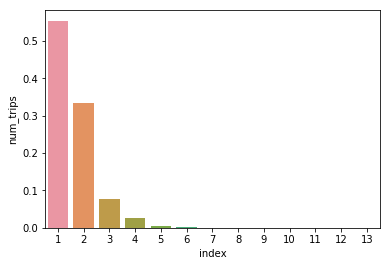

In [121]:
#sns.distplot(trips_per_user, hist=True)
#sns.violinplot(trips_per_user)
sns.barplot(x='index', y='num_trips', data=trips_per_user)

#### Compare with distribution of number of trips per user on a day on the original ticketing data

In [122]:
boarding_data.columns

Index([u'CODLINHA', u'NOMELINHA', u'CODVEICULO', u'NUMEROCARTAO',
       u'HORAUTILIZACAO', u'DATAUTILIZACAO', u'DATANASCIMENTO', u'SEXO',
       u'boarding_datetime'],
      dtype='object')

In [123]:
trips_per_user_original = boarding_data.groupby('NUMEROCARTAO').NUMEROCARTAO.count().reset_index(name='num_trips').num_trips.value_counts(normalize=True).reset_index(name='num_trips')

In [124]:
trips_per_user_original

,index,num_trips
0,1,0.500482
1,2,0.382923
2,3,0.078011
3,4,0.029663
4,5,0.004827
5,6,0.002977
6,7,0.000495
7,8,0.000396
8,9,0.000130
9,10,0.000094


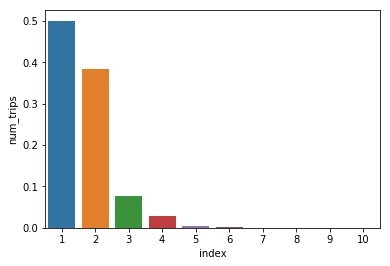

In [125]:
sns.barplot(x='index', y='num_trips', data=trips_per_user_original)

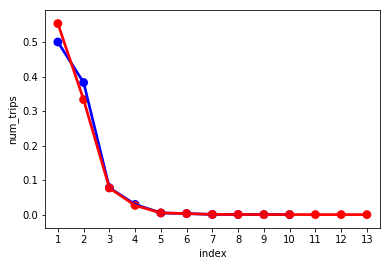

In [126]:
fig, ax = plt.subplots()
sns.pointplot(x='index', y='num_trips', data=trips_per_user_original, ax=ax, color='blue')
sns.pointplot(x='index', y='num_trips', data=trips_per_user, ax=ax, color='red')

#### Evaluate Missed Ticketing

In [91]:
missed_ticketing = pd.concat([final_buste_result[['cardNum','cardTimestamp','route','busCode']],
                              boarding_data[['NUMEROCARTAO','HORAUTILIZACAO','CODLINHA','CODVEICULO']] \
                                .rename(index=str, columns={'NUMEROCARTAO':'cardNum','HORAUTILIZACAO':'cardTimestamp',
                                                            'CODLINHA':'route','CODVEICULO':'busCode'})], axis=0) \
                    .drop_duplicates(subset=['cardNum','cardTimestamp'], keep=False)

In [92]:
missed_ticketing

,cardNum,cardTimestamp,route,busCode
16,1225547.0,18:10:41,684,HR417
19,2293790.0,17:46:39,040,JB605
27,3543165.0,17:54:09,OPC,HA295
36,1911991.0,15:23:48,000,06063
59,3752309.0,16:53:11,000,09032
63,3715544.0,15:12:37,050,JB602
82,2569091.0,05:40:47,242,BA115
88,3794425.0,08:04:10,000,05008
91,3184983.0,07:37:34,225,BA136
96,2977590.0,09:10:06,000,09035


In [93]:
missed_ticketing.describe(include='all')

,cardNum,cardTimestamp,route,busCode
count,4.360800e+04,43608,43608,43608
unique,NaN,27760,197,654
top,NaN,12:00:24,000,03010
freq,NaN,9,14243,1276
mean,2.996685e+06,NaN,NaN,NaN
std,1.126718e+06,NaN,NaN,NaN
min,2.286960e+05,NaN,NaN,NaN
25%,2.325180e+06,NaN,NaN,NaN
50%,3.229522e+06,NaN,NaN,NaN
75%,3.660669e+06,NaN,NaN,NaN


In [94]:
missed_ticketing.route.value_counts(normalize=True).head(10)

000    0.326614
OPC    0.138988
541    0.049028
684    0.021693
021    0.020959
050    0.018460
040    0.017313
816    0.016006
828    0.012108
523    0.011741
Name: route, dtype: float64

In [140]:
import os
import glob
import pandas as pd
import numpy as np
import time

In [145]:
st_time = time.time()

path = "/local/tarciso/masters/data/bus_trips/test/buste-version-its-april-2018/2017_05_09/"
allFiles = glob.glob(os.path.join(path,"*.csv"))


np_array_list = []
for file_ in allFiles:
    df = pd.read_csv(file_, dtype = {'route': str}, na_values='-')
    np_array_list.append(df.as_matrix())

comb_np_array = np.vstack(np_array_list)
big_frame = pd.DataFrame(comb_np_array)

#big_frame.columns = ['route', 'tripNum', 'shapeId', 'shapeSequence', 'shapeLat',
#       'shapeLon', 'distanceTraveledShape', 'busCode', 'gpsPointId',
#       'gpsLat', 'gpsLon', 'distanceToShapePoint', 'timestamp',
#       'stopPointId', 'problem', 'birthdate', 'cardTimestamp', 'lineName',
#       'cardNum', 'gender', 'date']

end_time = time.time()

print 'elapsed time (in secs):', end_time - st_time

elapsed time (in secs): 3.83566880226


In [146]:
st_time = time.time()

path = "/local/tarciso/masters/data/bus_trips/test/buste-version-its-april-2018/2017_05_09/"
allFiles = glob.glob(os.path.join(path,"*.csv"))

frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_, dtype = {'route': str}, na_values='-')
    list_.append(df)
frame = pd.concat(list_)

end_time = time.time()

print 'elapsed time (in secs):', end_time - st_time

elapsed time (in secs): 2.79075193405


In [137]:
big_frame.head()

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date
0,500,1,4130,6463875,-25.5015,-49.2376,2129.86,GE718,NaN,NaN,...,NaN,06:37:02,27472,BETWEEN,NaN,NaN,NaN,NaN,NaN,2017_05_09
1,500,1,4130,6463945,-25.4818,-49.247,4513.26,GE718,NaN,-25.4817,...,15.5618,06:42:45,27551,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017_05_09
2,500,1,4130,6464041,-25.4592,-49.2582,7268.13,GE718,NaN,NaN,...,NaN,06:47:54,25471,BETWEEN,NaN,NaN,NaN,NaN,NaN,2017_05_09
3,500,1,4130,6464140,-25.4388,-49.2681,9735.97,GE718,NaN,-25.4387,...,12.1053,06:53:44,25515,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017_05_09
4,500,1,4130,6464167,-25.4338,-49.2703,10543.4,GE718,NaN,-25.4339,...,21.5561,06:58:25,27560,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017_05_09
